# Tarea 1: Introducción a los estimadores de Error A posteriori
#### Nombre: Ignacio Ruminot Aburto - iruminot@udec.cl

#### Problema 2. (Parte Computacional)
Considere el problema de valor de contorno
$$
 \begin{aligned}
-u^{\prime \prime} (x) + 20 u^{\prime} (x) + 10 u(x) &= 1, \quad x \in \Omega:= (0,1) \\
u(0) &= 0 \\
u(1) & = 0,
\end{aligned}
$$
cuya solución exacta es
$$ u (x) = \left( \frac{e^{\lambda_2}-1}{10 \left( e^{\lambda_1} - e^{\lambda_2} \right)} \right)e^{\lambda_1 x} + \left(\frac{1-e^{\lambda_1}}{10 \left( e^{\lambda_1} - e^{\lambda_2} \right)} \right)e^{\lambda_2 x} +\frac{1}{10}, \quad \text{siendo } \lambda_1 = 10 +\sqrt{10}, \lambda_2 = 10 -\sqrt{10}. $$

La formulación variacional continua asociada al PCV es: Hallar $u \in H_0^1 (\Omega)$ tal que $a(u,v) = F (v)$, $\forall v \in H_0^1 (\Omega)$, donde
$$ a(u,v) := \int_{\Omega}{u^{\prime} v^{\prime}} + 20 \int_{\Omega}{u^{\prime} v}+ 10\int_{\Omega}{uv}, \quad F(v) := \int_{\Omega}{v}$$

Además, por teorema de Lax-Milgram tiene solución única. (ver informe AGREGAR LINK)

In [1]:
#Librerias necesarias para poder compilar
import ngsolve
from ngsolve import *
from netgen.meshing import *
import os
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [2]:
## Definición de funciones que se utilizarán en el código.
def normas(x_vals,uh):
    #Input: x_vals: nodos del mallado, uh: solución aproximada
    #Output: Devuelve en una lista la norma L2, semi-norma H1 y norma H1 locales
    errorL2=[]
    errorsH1=[]
    errorH1=[]
    lambda1=10+np.sqrt(110)
    lambda2=10-np.sqrt(110)
    for i in range(len(x_vals)-2):
        ff1=lambda xx: (((np.exp(lambda2)-1)/(10*(np.exp(lambda1)-np.exp(lambda2))))*np.exp(lambda1*xx)+((1-np.exp(lambda1))/(10*(np.exp(lambda1)-np.exp(lambda2))))*np.exp(lambda2*xx)+1/10-uh[i+1]*((x_vals[i+2]-xx)/(x_vals[i+2]-x_vals[i+1])) - uh[i+2]*((xx-x_vals[i+1])/(x_vals[i+2]-x_vals[i+1])))**2
        I1,e = quad(ff1, x_vals[i+1], x_vals[i+2])
        errorL2.append(I1)
    
        ff2=lambda xx: (((np.exp(lambda2)-1)/(10*(np.exp(lambda1)-np.exp(lambda2))))*np.exp(lambda1*xx)*lambda1+((1-np.exp(lambda1))/(10*(np.exp(lambda1)-np.exp(lambda2))))*np.exp(lambda2*xx)*lambda2-(1/(x_vals[i+2]-x_vals[i+1]))*(uh[i+2]-uh[i+1]))**2
        I2,e = quad(ff2, x_vals[i+1], x_vals[i+2])
        errorsH1.append(I2)

        errorH1.append(I1+I2)
    return errorL2,errorsH1,errorH1

def r_exp(h,errorL2,errorH1):
    #Input: h: tamaños de paso, errorL1: vector de error L2, errorH1: vector de error H1
    #Output: Devuelve en una lista los ordenes de convergencia experimentales asociado a la norma ingresada
    rL2=[]
    rH1=[]
    errorL2 = np.array(errorL2, dtype=float)
    errorH1 = np.array(errorH1, dtype=float)
    for i in range(len(h)):
        if i==0:
            rL2.append('-')
            rH1.append('-')
        else:
            rL2.append(np.log(errorL2[i-1]/errorL2[i])/np.log(h[i-1]/h[i]))
            rH1.append(np.log(errorH1[i-1]/errorH1[i])/np.log(h[i-1]/h[i]))
    return rL2,rH1

def geometry_1D():
    # Define la geometria del problema
    geometry = Mesh(dim=1)
    N = 2**n
    pnums = []
    for i in range(0, N+1):
        pnums.append (geometry.Add (MeshPoint (Pnt(i/N, 0, 0))))
    idx = geometry.AddRegion("material", dim=1)
    for i in range(0,N):
        geometry.Add (Element1D ([pnums[i],pnums[i+1]], index=idx))
    idx_left = geometry.AddRegion("left", dim=0)
    idx_right = geometry.AddRegion("right", dim=0)

    geometry.Add (Element0D (pnums[0], index=idx_left))
    geometry.Add (Element0D (pnums[N], index=idx_right))
    return geometry , N

## (b) Refinamiento Uniforme
Resuelve el problema usando el método de elementos finitos del orden más bajo de aproximación posible, y tabule los errores en $\left\| \cdot \right\|_{H^{1} (\Omega)}$ y $\left\| \cdot \right\|_{L^{2} (\Omega)}$, así como los órdenes de convergencia experimentales correspondientes para $h = \dfrac{1}{2^{n}}$, $n \in \left\lbrace 1,2,3,4,5,6,7,8,9,10 \right\rbrace$.

In [3]:
# Solución exacta escrita de forma simbólica
x=sp.symbols('x')
lambda1=10+sp.sqrt(110)
lambda2=10-sp.sqrt(110)
sol_exact = ((sp.exp(lambda2)-1)/(10*(sp.exp(lambda1)-sp.exp(lambda2))))*sp.exp(lambda1*x)+((1-sp.exp(lambda1))/(10*(sp.exp(lambda1)-sp.exp(lambda2))))*sp.exp(lambda2*x)+1/10
f_num = sp.lambdify(x, sol_exact, modules=['numpy'])
sol_exact


(1 - exp(10 + sqrt(110)))*exp(x*(10 - sqrt(110)))/(-10*exp(10 - sqrt(110)) + 10*exp(10 + sqrt(110))) + (-1 + exp(10 - sqrt(110)))*exp(x*(10 + sqrt(110)))/(-10*exp(10 - sqrt(110)) + 10*exp(10 + sqrt(110))) + 0.1

In [4]:
# Derivada de la olución exacta escrita de forma simbólica
diff_sol_exact=sp.diff(sol_exact,x)
diff_sol_exact

(1 - exp(10 + sqrt(110)))*(10 - sqrt(110))*exp(x*(10 - sqrt(110)))/(-10*exp(10 - sqrt(110)) + 10*exp(10 + sqrt(110))) + (-1 + exp(10 - sqrt(110)))*(10 + sqrt(110))*exp(x*(10 + sqrt(110)))/(-10*exp(10 - sqrt(110)) + 10*exp(10 + sqrt(110)))

A continuación se presenta el codigo que resuelve el PVC a través de elementos finitos lineales. Además se ilustran algunas gráficas de las iteraciones del refinamiento uniforme.


Iteración de refinamiento:  1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


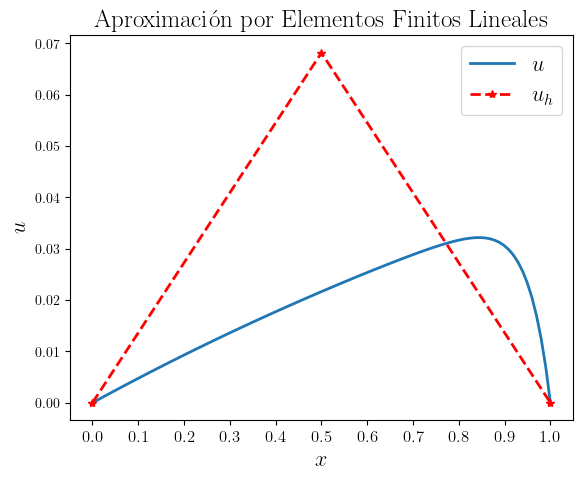

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  2


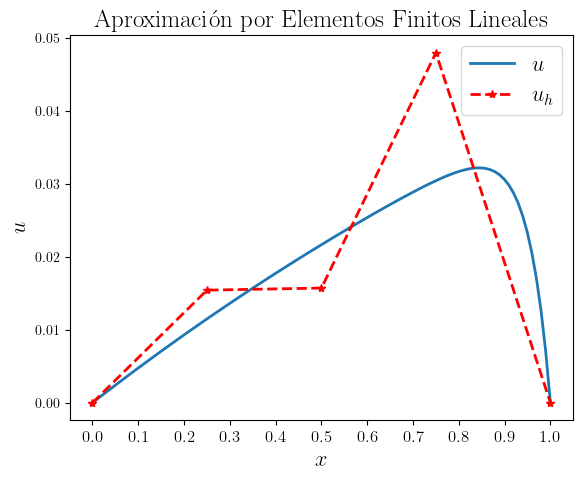

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  3


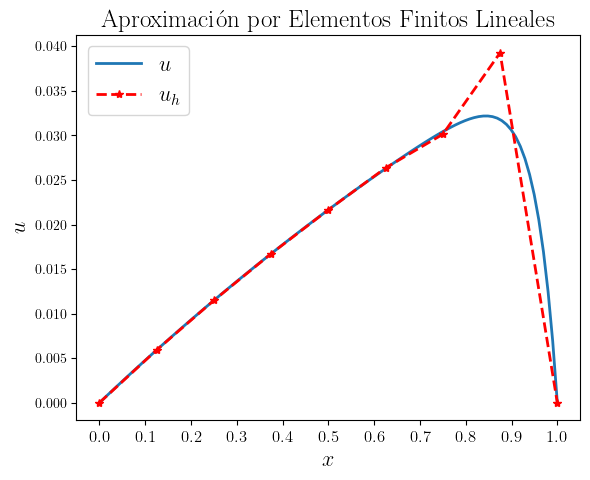

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  6


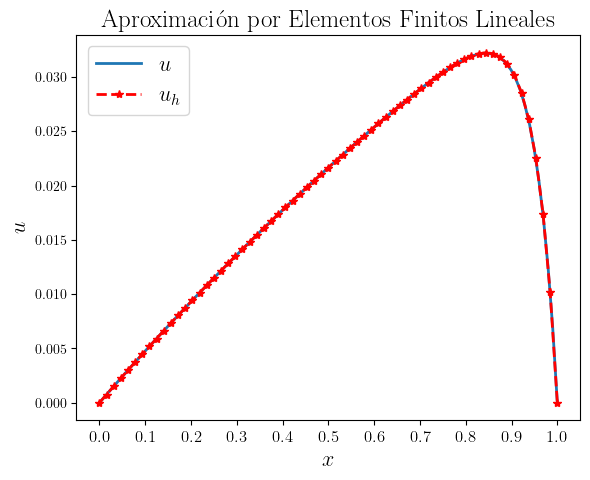

In [5]:
# Se crean diferentes litas que almacenan datos utilices.
ndofs=[] # Número de grados de libertad
nnodos=[] # Cantidad de nodos
h=[] # Tamaños de paso
errorL2=[] # Errores en norma L2
errorsH1=[] # Errores en semi-norma H1
errorH1=[] # Errores en norma H1
count=1 # Contador de iteraciones
for n in range(10):
    n=n+1 # n en {1,2,3,4,5,6,7,8,9,10}

    # Mallado
    geo , N = geometry_1D() # Crea la estructura de la geometría
    mesh = ngsolve.Mesh(geo) # Crea el mallado a partir de la geometría
    
    # Declaración del espacio de aproximación de elementos finitos
    fes = H1(mesh, order=1, dirichlet='left|right')
    
    # Declaración de elementos simbolicos u,v en el espacio de aproximación
    u, v = fes.TnT()
    gfu = GridFunction(fes) # Crea el vector solución por elementos finitos
    
    # Declara la forma bilineal a
    a = BilinearForm(fes)
    a += SymbolicBFI(grad(u)*grad(v)+20*grad(u)*v+10*u*v)
    a.Assemble()
    # Declara el funcional lineal F
    f = CoefficientFunction(1) # Fuente externa f=1
    F = LinearForm(fes)    
    F += SymbolicLFI(f*v)
    F.Assemble()
    
    # Solución del sistema lineal
    gfu.vec.data = a.mat.Inverse(fes.FreeDofs()) * F.vec
    uh = gfu.vec.FV().NumPy() # Cambia el formato de dato de la solución
    
    # Puntos del mallado
    pnts=[]
    for i,p in enumerate(mesh.ngmesh.Points()):
        pnts.append(p[0]) 
    x_vals = np.array(pnts, dtype=float) # Contiene los puntos en el eje X del mallado
    
    # Calculo y almacenamiento de datos relevantes
    ndofs.append(sum(fes.FreeDofs())) # Cantidad de dofs de la iteración
    nnodos.append(mesh.nv) # Cantidad de nodos de la iteración
    h.append(1/2**n) # Tamaño de paso utilizado en la iteración
    a,b,c = normas(x_vals,uh) # Cálculo de las normas (locales)
    errorL2.append("{:.4e}".format(np.sqrt(np.sum(a)))) # Almacena la norma L2 global 
    errorsH1.append("{:.4e}".format(np.sqrt(np.sum(b)))) # Almacena la semi-norma H1 global 
    errorH1.append("{:.4e}".format(np.sqrt(np.sum(c)))) # Almacena la norma H1 global 
    
    # Graficas
    if count==1 or count==2  or count ==3 or count == 6:
        print('\nIteración de refinamiento: ',count)
        xx = np.linspace(0,1,100)
        plt.figure(figsize=(6.5, 5))
        plt.plot(xx, f_num(xx), label='$u$',linewidth=2)
        plt.plot(pnts,uh, '--r*',label='$u_h$',linewidth=2)
        plt.legend()
        plt.legend(fontsize=16)
        plt.title('Aproximación por Elementos Finitos Lineales', fontsize=18)
        plt.xlabel('$x$', fontsize=16)
        plt.ylabel('$u$', fontsize=16)
        custom_xticks = np.arange(0, 1.1, 0.1)
        plt.xticks(custom_xticks, fontsize=12)
        output_file = os.path.join('img/2', 'ru_'+str(count)+'.eps')
        plt.savefig(output_file, format='eps')
        plt.show()
    count=count+1

# Cálculo de ordenes de convergencia experimental
rL2,rH1=r_exp(h,errorL2,errorH1)

De las gráficas anteriores se puede evidenciar que a medida que aumenta la cantidad de nodos de la malla, la aproximación mejora significativamente.

Una vez encontrados los datos a través de la implementación numérica, podemos contruir la siguiente tabla:

In [6]:
datos={'NDOFS': ndofs , 'h': h, 'norma H1': errorH1, 'r_1 (u)': rH1,'norma L2': errorL2,'r_0 (u)':rL2}
df=pd.DataFrame(datos)
df.style.hide()

NDOFS,h,norma H1,r_1 (u),norma L2,r_0 (u)
1,0.500000,1.3080e-01,-,1.5167e-02,-
3,0.250000,1.1552e-01,0.179220,6.8380e-03,1.149289
7,0.125000,7.7637e-02,0.573326,2.3196e-03,1.559698
15,0.062500,4.3685e-02,0.829606,6.5712e-04,1.819647
31,0.031250,2.2613e-02,0.949986,1.7038e-04,1.947401
63,0.015625,1.1409e-02,0.986980,4.3003e-05,1.986247
127,0.007812,5.7178e-03,0.996640,1.0777e-05,1.996482
255,0.003906,2.8606e-03,0.999142,2.6958e-06,1.999170
511,0.001953,1.4305e-03,0.999798,6.7405e-07,1.999786
1023,0.000977,7.1527e-04,0.999960,1.6852e-07,1.999936


De la tabla de datos, podemos identificar que el orden de convergencia experimental $r_1 (u) \approx 1$ y $r_0 (u) \approx 2$ a medida que aumenta la cantidad de grados de libertad, por lo que se cumple lo predicho por la teoría tanto para la norma $\left\| \cdot \right\|_{H^{1} (\Omega)}$ como para la norma $\left\| \cdot \right\|_{L^{2} (\Omega)}$

Y por último se puede observar la gráfica loglog de los grados de libertad versus las normas. Aqui podemos ver graficamente como la norma L2 decae más rápido que la norma H1.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


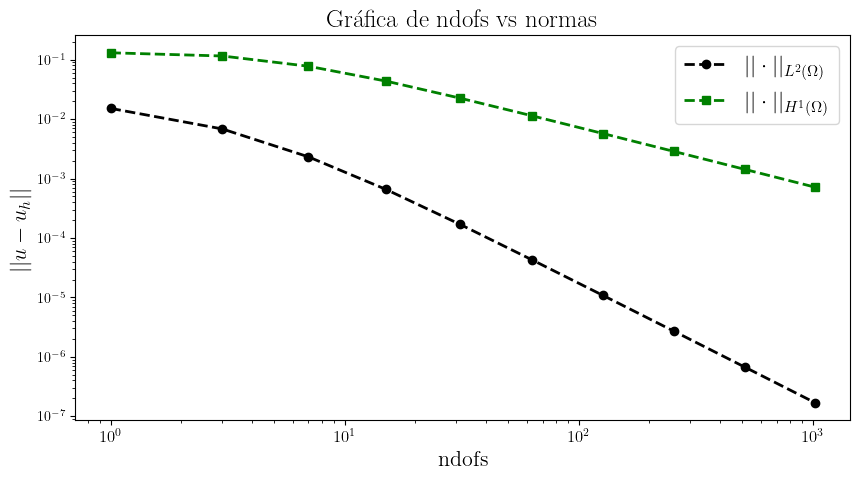

In [7]:
plt.figure(figsize=(10, 5))
plt.loglog(np.transpose(ndofs), np.array(errorL2, dtype=float),'--ko', label='$|| \cdot ||_{L^{2} (\Omega)}$',linewidth=2)
plt.loglog(np.transpose(ndofs), np.array(errorH1, dtype=float),'--gs', label='$|| \cdot ||_{H^{1} (\Omega)}$',linewidth=2)
plt.xlabel('ndofs', fontsize=16)
plt.ylabel('$|| u - u_h ||$', fontsize=16)
plt.title('Gráfica de ndofs vs normas',fontsize=18)
plt.legend()
plt.legend(fontsize=16)
custom_xticks = [10**0, 10**1 , 10**2 , 10**3]
plt.xticks(custom_xticks, fontsize=12)
output_file = os.path.join('img/2', 'errorru_u.eps')
plt.savefig(output_file, format='eps')
plt.show()

## Refinamiento Adaptativo

Para el refinamiento adaptativo se considera la estrategia o algoritmo
$$ \text{Solve } \longrightarrow \text{ Estimation } \longrightarrow \text{ Mark } \longrightarrow \text{Refine}. $$

Donde _Solver_ del PVC utiliza un espacio de elementos finitos lineales $V_h$ que se define como
$$ V_h := \left\lbrace v \in \mathcal{C}(\overline{\Omega}): \forall j \in \lbrace 1, \ldots , N \rbrace  : \left. v \right|_{\overline{\Omega}_j} \in \mathbb{P}_1 ({\overline{\Omega}_j}), v (x_0) = v (x_{N+1}) = 0 \right\rbrace .$$

Para _Estimación_ se utiliza un estimador a posteriori definido como $\displaystyle{\eta := \left( \sum_{j=1}^{N+1}{\eta_j^2} \right)^{1/2}}$, $\eta_j := h_j^2 \left\| f - \beta u_h^{\prime} \right\|_{0,\Omega_j}$.

En _Mark_ se utiliza la estragia de marcado del maximo, es decir $\displaystyle{\forall \mathcal{T}_h : \eta_h \geq \frac{1}{4} \max_{j}{\lbrace \eta_j \rbrace}}$.

_Refine_ toma el mallado $\mathcal{T}_h$ y refina en todos los elementos marcados $x_k$ agregando nuevos nodos $\displaystyle{\frac{x_k + x_{k+1}}{2}}$, generando un nuevo mallado refinado $\mathcal{T}_{\tilde{h}}$ y resolviendo nuevamente con esta nueva malla.



In [8]:
def mesh_estimate(x_vals,uh):
    #Input: x_vals: nodos del mallado, uh: solución aproximada
    #Output: Devuelve una lista con los estimados locales y el maximo entre ellos
    eta=[]
    for i in range(len(x_vals)-2):
        ff=lambda xx: (1-20*((1/(x_vals[i+2]-x_vals[i+1]))*(uh[i+2]-uh[i+1]))-10*(uh[i+2]*((x_vals[i+2]-xx)/(x_vals[i+2]-x_vals[i+1])) + uh[i+1]*((xx-x_vals[i+1])/(x_vals[i+2]-x_vals[i+1]))))**2
        I,e = quad(ff, x_vals[i+1], x_vals[i+2])
        eta.append((x_vals[i+2]-x_vals[i+1])**2*np.sqrt(I)) 
    return np.array(eta, dtype=float), float(max(eta))

def mesh_refine():
    #Output: Devuelve un mallado refinado
    geometry = Mesh(dim=1)
    mesh_points=x_vals.tolist()
    pnums=[]
    for k in reversed(indice):
        mesh_points.insert(k+1,(mesh_points[k]+mesh_points[k+1])/2)

    for i in mesh_points:
        pnums.append(geometry.Add(MeshPoint(Pnt(i, 0, 0))))

    idx = geometry.AddRegion("material", dim=1)
    for i in range(len(pnums)-1):
        geometry.Add(Element1D([pnums[i],pnums[i+1]], index=idx))
    idx_left = geometry.AddRegion("left", dim=0)
    idx_right = geometry.AddRegion("right", dim=0)

    geometry.Add (Element0D (pnums[0], index=idx_left))
    geometry.Add (Element0D (pnums[len(pnums)-1], index=idx_right))
    return geometry

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  1


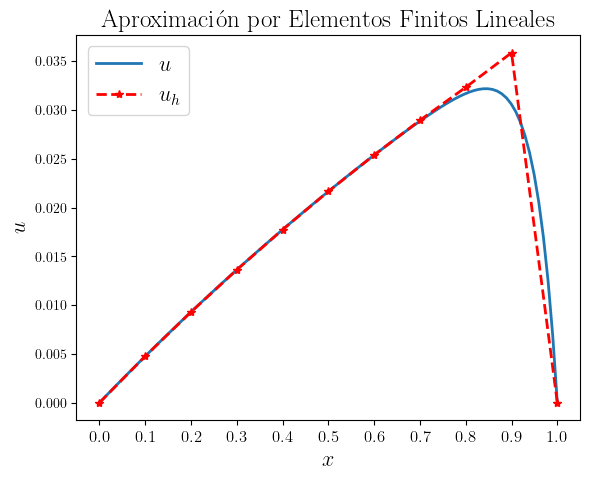

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  3


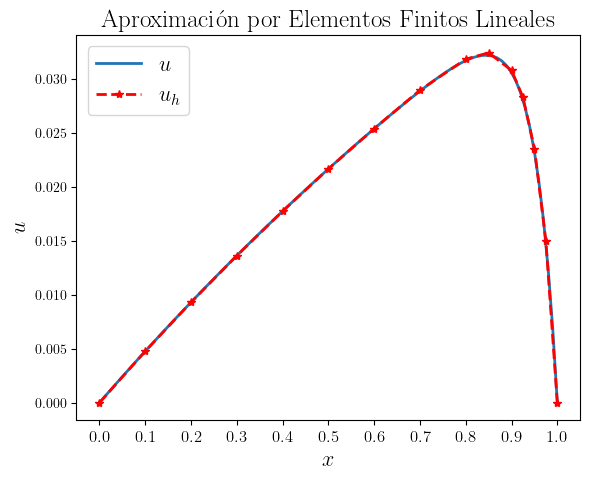

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  5


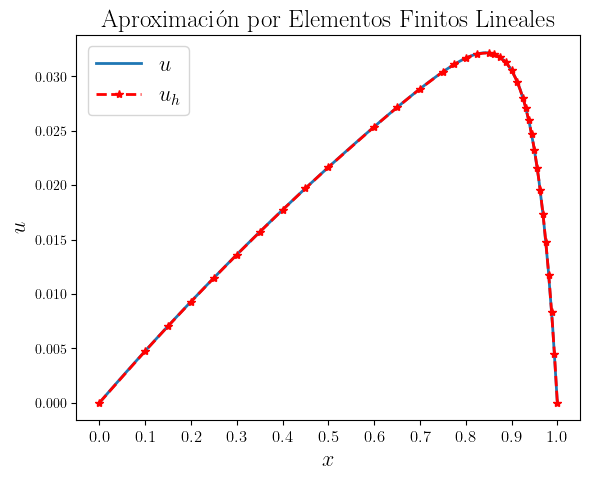

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



Iteración de refinamiento:  7


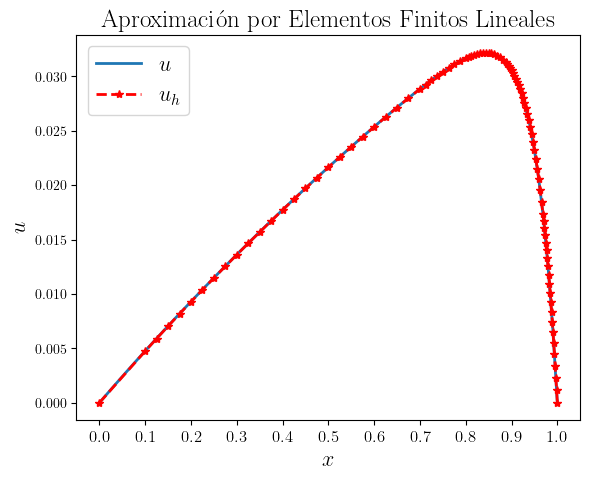

In [9]:
# Se definen listas para almacenar elementos
ndofs=[]
nnodos=[]
errorL2=[]
errorsH1=[]
errorH1=[]
eta=[]
count = 1

# Se define el mallado inicial
geometry = Mesh(dim=1)
h0=1/10
N=10
pnums = []
for i in range(0, N+1):
    pnums.append (geometry.Add (MeshPoint (Pnt(i*h0, 0, 0))))
idx = geometry.AddRegion("material", dim=1)
for i in range(0,N):
    geometry.Add (Element1D ([pnums[i],pnums[i+1]], index=idx))
idx_left = geometry.AddRegion("left", dim=0)
idx_right = geometry.AddRegion("right", dim=0)

geometry.Add (Element0D (pnums[0], index=idx_left))
geometry.Add (Element0D (pnums[N], index=idx_right))

mesh = ngsolve.Mesh(geometry)

while count < 10:
    fes = H1(mesh, order=1, dirichlet='left|right')
    u, v = fes.TnT()
    gfu = GridFunction(fes) 
    #a = BilinearForm(fes, symmetric=True)
    a = BilinearForm(fes)
    a += SymbolicBFI(grad(u)*grad(v)+20*grad(u)*v+10*u*v)
    a.Assemble()
    #    Forcing function
    f = CoefficientFunction(1)
    F = LinearForm(fes)    
    F += SymbolicLFI(f*v)
    F.Assemble()
    gfu = GridFunction(fes)
    gfu.vec.data = a.mat.Inverse(fes.FreeDofs()) * F.vec
    uh = gfu.vec.FV().NumPy()
    
    pnts=[]
    for i,p in enumerate(mesh.ngmesh.Points()):
        pnts.append(p[0]) 
    
    x_vals = np.array(pnts, dtype=float)
    
    if count==1 or count==3  or count ==5 or count == 7:
        print('\nIteración de refinamiento: ',count)
        xx = np.linspace(0,1,100)
        plt.figure(figsize=(6.5, 5))
        plt.plot(xx, f_num(xx), label='$u$',linewidth=2)
        plt.plot(pnts,uh, '--r*',label='$u_h$',linewidth=2)
        plt.legend()
        plt.legend(fontsize=16)
        plt.title('Aproximación por Elementos Finitos Lineales', fontsize=18)
        plt.xlabel('$x$', fontsize=16)
        plt.ylabel('$u$', fontsize=16)
        custom_xticks = np.arange(0, 1.1, 0.1)
        plt.xticks(custom_xticks, fontsize=12)
        output_file = os.path.join('img/2', 'ra_'+str(count)+'.eps')
        plt.savefig(output_file, format='eps')
        plt.show()
    
    etalocal,maxerr = mesh_estimate(x_vals,uh)
    indice = [i+1 for i in range(len(x_vals)-2) if etalocal[i] > 0.25 * maxerr]
    
    ndofs.append(sum(fes.FreeDofs()))
    nnodos.append(mesh.nv)
    a,b,c = normas(x_vals,uh)
    errorL2.append("{:.4e}".format(np.sqrt(np.sum(a))))
    errorsH1.append("{:.4e}".format(np.sqrt(np.sum(b))))
    errorH1.append("{:.4e}".format(np.sqrt(np.sum(c))))
    eta.append("{:.4e}".format(np.sqrt(np.sum(etalocal**2))))
        
    count=count+1
    geometry = mesh_refine()
    mesh = ngsolve.Mesh(geometry)
    
rL2,rH1=r_exp([1/x for x in nnodos],errorL2,errorH1)

De las gráficas anteriores se puede evidenciar que a medida que aumenta la cantidad de nodos de la malla como efecto del refinamiento adaptativo, la aproximación mejora significativamente localizando los nodos donde los errores eran mayores.

Una vez encontrados los datos a través de la implementación numérica, podemos contruir la siguiente tabla:

In [10]:
datos={'NDOFS': ndofs , 'norma H1': errorH1, 'r H1': rH1 ,  'normaL2': errorL2 ,'r L2': rL2, 'eta': eta}
df=pd.DataFrame(datos)
df.style.hide()

NDOFS,norma H1,r H1,normaL2,r L2,eta
9,6.5497e-02,-,1.5706e-03,-,2.5278e-02
10,3.6117e-02,6.840952,4.3468e-04,14.763620,6.8545e-03
13,1.8610e-02,2.971471,1.1429e-04,5.986599,1.8084e-03
18,9.8631e-03,2.206945,3.7090e-05,3.911928,6.2051e-04
34,4.9559e-03,1.170870,1.6426e-05,1.385676,1.7772e-04
52,2.8613e-03,1.354747,1.4146e-05,0.368548,6.8522e-05
92,1.6140e-03,1.032923,1.3711e-05,0.056346,2.1674e-05
165,9.8086e-04,0.866612,1.3665e-05,0.005848,6.8903e-06
291,6.0929e-04,0.846947,1.3665e-05,0.000000,2.2756e-06


Para finalizar, se ilustran las gráficas de las normas versus los grados de libertad donde se observa al aumentar los grados de libertad, los errores disminuyen hasta estabilizarse. Además, la gráfica del estimador a posteriori versus la norma L2, donde se observa que al dismiuir el estimador, tambien disminuye la norma L2 hasta estabilizarse.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


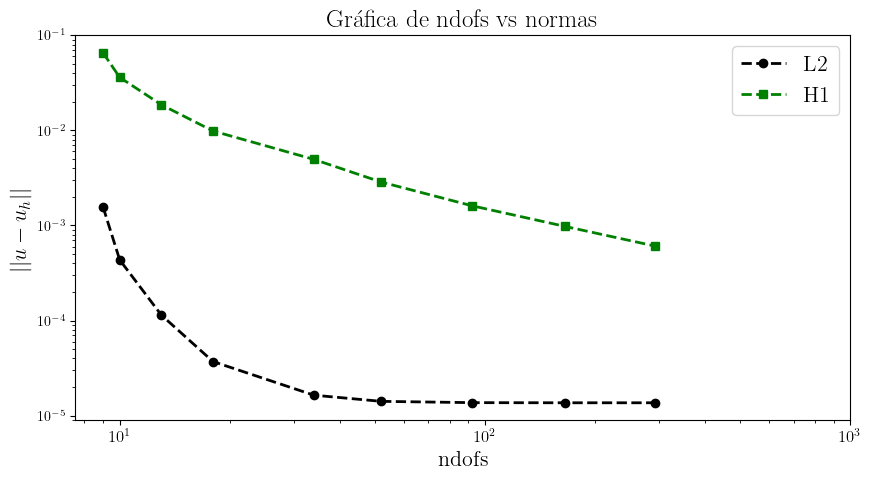

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


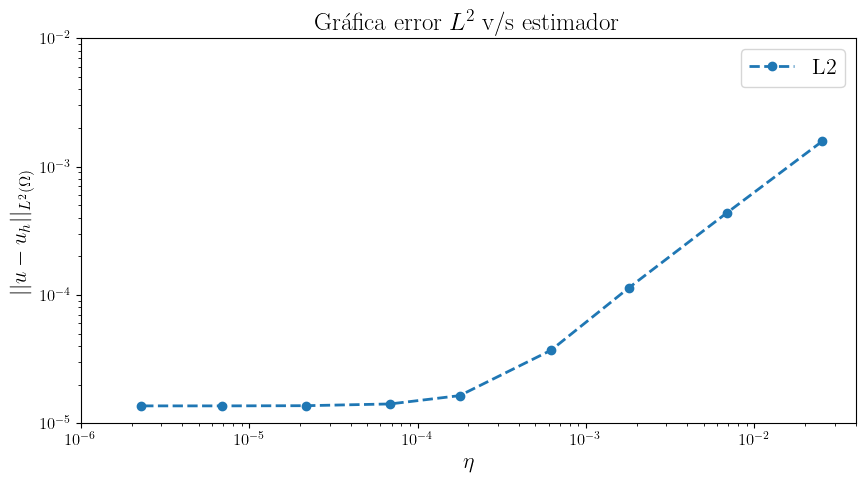

In [11]:
plt.figure(figsize=(10, 5))
plt.loglog(np.transpose(ndofs), np.array(errorL2, dtype=float),'--ko', label='L2',linewidth=2)
plt.loglog(np.transpose(ndofs), np.array(errorH1, dtype=float),'--gs', label='H1',linewidth=2)
plt.xlabel('ndofs', fontsize=16)
plt.ylabel('$|| u - u_h ||$', fontsize=16)
plt.title('Gráfica de ndofs vs normas',fontsize=18)
plt.legend()
plt.legend(fontsize=16)
custom_xticks = [10**1 , 10**2 , 10**3]
plt.xticks(custom_xticks, fontsize=12)
output_file = os.path.join('img/2', 'errorra_u.eps')
plt.savefig(output_file, format='eps')
plt.show()

plt.figure(figsize=(10, 5))
plt.loglog(np.array(eta, dtype=float),np.array(errorL2, dtype=float),'--o', label='L2',linewidth=2)
plt.ylabel('$|| u - u_h ||_{L^{2} (\Omega)}$',fontsize=16)
plt.xlabel('$\eta$',fontsize=16)
plt.title(' Gráfica error $L^2$ v/s estimador',fontsize=18)
plt.legend()
plt.legend(fontsize=16)
custom_xticks = [10**-6,10**-5,10**-4 , 10**-3 , 10**-2 ]
plt.xticks(custom_xticks, fontsize=12)
custom_yticks = [10**-5,10**-4 , 10**-3 , 10**-2 ]
plt.yticks(custom_yticks, fontsize=12)
output_file = os.path.join('img/2', 'estimador.eps')
plt.savefig(output_file, format='eps')
plt.show()